<center> <h1> Natural Language Processing - Assignment # 1 </h1> 
    Lorenzo Pratesi <a href="mailto:lorenzo.pratesi2@studio.unibo.it">lorenzo.pratesi2@studio.unibo.it</a> <br>
        Martina Rossini <a href="mailto:martina.rossini3@studio.unibo.it">martina.rossini3@studio.unibo.it</a> <br>
        Riccardo Foschi <a href="mailto:riccardo.foschi4@studio.unibo.it">riccardo.foschi4@studio.unibo.it</a> <br>
        Vairo Di Pasquale <a href="mailto:vairo.dipasquale@studio.unibo.it">vairo.dipasquale@studio.unibo.it</a>
    <center>
    

## Table of Contents
* [Download and prepare the dataset](#Download-and-prepare-the-dataset)
* [Downloading GloVe Embeddings](#Downloading-GloVe-Embeddings)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
	* [Checking OOV terms](#Checking-OOV-terms)
* [Create numeric mappings for sentences and POS tags](#Create-numeric-mappings-for-sentences-and-POS-tags)
* [Generate Embedding Matrix](#Generate-Embedding-Matrix)
* [Sanity Checks](#Sanity-Checks)
* [Pad sequences](#Pad-sequences)
* [Defining the model](#Defining-the-model)
* [Defining Model Evaluations](#Defining-Model-Evaluations)
	* [Early Stopping criterion](#Early-Stopping-criterion)
* [Building and training the models](#Building-and-training-the-models)
	* [Building the baseline RNN model](#Building-the-baseline-RNN-model)
	* [Building the baseline model with an additional LSTM layer](#Building-the-baseline-model-with-an-additional-LSTM-layer)
	* [Building baseline model with GRU layer](#Building-baseline-model-with-GRU-layer)
	* [Building baseline model with an additional Dense layer](#Building-baseline-model-with-an-additional-Dense-layer)
* [Showing the results for each model](#Showing-the-results-for-each-model)
	* [Discussing results](#Discussing-results)
* [Hyperparameters tuning](#Hyperparameters-tuning)
	* [Using bigger GloVe embeddings](#Using-bigger-GloVe-embeddings)
	* [Sample Weights](#Sample-Weights)
	* [Using bigger size of LSTM hidden states](#Using-bigger-size-of-LSTM-hidden-states)
    * [Gradient Normalization and Clipping](#Gradient-Normalization-and-Clipping)
	* [Regularization](#Regularization)


### Download and prepare the dataset

We'll start by installing and then importing the necessary libraries.

In [ ]:
!pip install gensim==4.0.0
!pip install wordcloud==1.8.1

     |████████████████████████████████| 23.9 MB 1.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 366 kB 5.4 MB/s 
  Attempting uninstall: wordcloud
    Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0


In [ ]:
# General Python libraries
import os
from tqdm import tqdm
from urllib import request
from zipfile import ZipFile

# Data processing libraries
import re
import numpy as np
import pandas as pd

# Plotting libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import wordcloud

# Machine Learning / Deep Learning / Language modelling libraries
import gensim
import gensim.downloader as gloader

from tensorflow.random import set_seed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Input, Dense, TimeDistributed, Dropout

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Once the imports are done, we can proceed by downloading and extracting the given dataset.

In [ ]:
file_path = 'data/treebank.zip'

if 'data' not in os.listdir():
    os.mkdir('data')

# Download
request.urlretrieve(
    'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip', 
    file_path)

('data/treebank.zip', <http.client.HTTPMessage at 0x7f386adc0550>)

In [ ]:
# Extract
with ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('data/')

In [ ]:
# Setting random seed for reproducibility
np.random.seed(42)
set_seed(42)

According to the assignment specifications, we then divide the input files in train, test and validation sets. We also choose to split each document into sentences, which can be easily detected from the <code> .dp </code> files, as they are separated by <code>\n</code>.  

Thus, the input of our model during train will be a sequence of pairs <code>(token, pos_tag)</code> and it will have a lenght which is in the order of the maximum lenght of a sentence. 

In [ ]:
data = {'train': pd.DataFrame(columns=['sentence', 'pos']), 
        'test': pd.DataFrame(columns=['sentence', 'pos']), 
        'validation': pd.DataFrame(columns=['sentence', 'pos'])}

for filename in sorted(os.listdir("data/dependency_treebank")):
    with open("data/dependency_treebank/" + filename, 'r') as f:
        file_no = int(filename.split('_')[1][:-3])
        if file_no <= 100:
            name = 'train'
        elif file_no <= 150:
            name = 'validation'
        else:
            name = 'test'
        # Read the whole file in a pandas dataframe. Blank lines are
        # read as NaNs
        df = pd.read_table(
            "data/dependency_treebank/" + filename, 
            delimiter='\t', 
            names=['word', 'pos'], 
            usecols=[0,1],
            skip_blank_lines=False)
        
        # Detect NaN rows and split on them to generate sentences
        idx = list(df.loc[df.isnull()['word']].index)
        idx.append(len(df))
        prev = 0
        for sep in idx:
            df_sen = pd.DataFrame({
                'sentence': [df['word'][prev:sep].to_list()], 
                'pos' :[df['pos'][prev:sep].to_list()]})
            data[name] = pd.concat([data[name], df_sen], ignore_index=True)
            prev = sep + 1

Let's now look at some sample sentences from our training set

In [ ]:
data['train'].head(3)

,sentence,pos
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."


In [ ]:
print(data['train']['sentence'][0])
print(data['train']['sentence'][1])
print(data['train']['sentence'][2])
print(data['train']['sentence'][3])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.']
['Rudolph', 'Agnew', ',', '55', 'years', 'old', 'and', 'former', 'chairman', 'of', 'Consolidated', 'Gold', 'Fields', 'PLC', ',', 'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this', 'British', 'industrial', 'conglomerate', '.']
['A', 'form', 'of', 'asbestos', 'once', 'used', 'to', 'make', 'Kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group', 'of', 'workers', 'exposed', 'to', 'it', 'more', 'than', '30', 'years', 'ago', ',', 'researchers', 'reported', '.']


### Downloading GloVe Embeddings

We now need to download the pre-trained GloVe embeddings using the gensim library. Note that we choose to use 50 as embedding size.

In [ ]:
def load_glove(embedding_dimension=50):
    """
    Load pre-computed GloVe embeddings using the gensim library.

    Parameters
    ----------
    embedding_dimension: {50, 100, 200, 300}, default: 50
        Dimension of the vectors to load. 
    
    Returns
    -------
    gensim.models.keyedvectors
        Gensim model containing the requested embeddings
    """
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e
    return emb_model

EMBEDDING_DIM = 50
gloves = load_glove(EMBEDDING_DIM)

[==================================================] 100.0% 66.0/66.0MB downloaded


### Exploratory Data Analysis

First, we split our data in sentences and POS tags - basically obtaining both the column that will be an input to our models and the columns that will serve as the ground truth during our experiments. Then, we perfom exploratory data analysis on the obtained data, with a special focus on investigating the characteristics of the train set.

In [ ]:
X_train = data['train']['sentence']
y_train = data['train']['pos']

X_val = data['validation']['sentence']
y_val = data['validation']['pos']

X_test = data['test']['sentence']
y_test = data['test']['pos']

Let's visualize how many samples are contained in each dataset and show the distrubution of the classes (i.e.: the single POS tags) in both train and validation set.

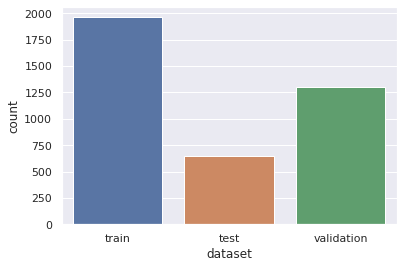

In [ ]:
# Counting the samples in each data split
sns.set(color_codes=True)

concatenated = pd.concat([data[split].assign(dataset=split) for split in data.keys()])

sns.countplot(x='dataset', data=concatenated)
plt.show()

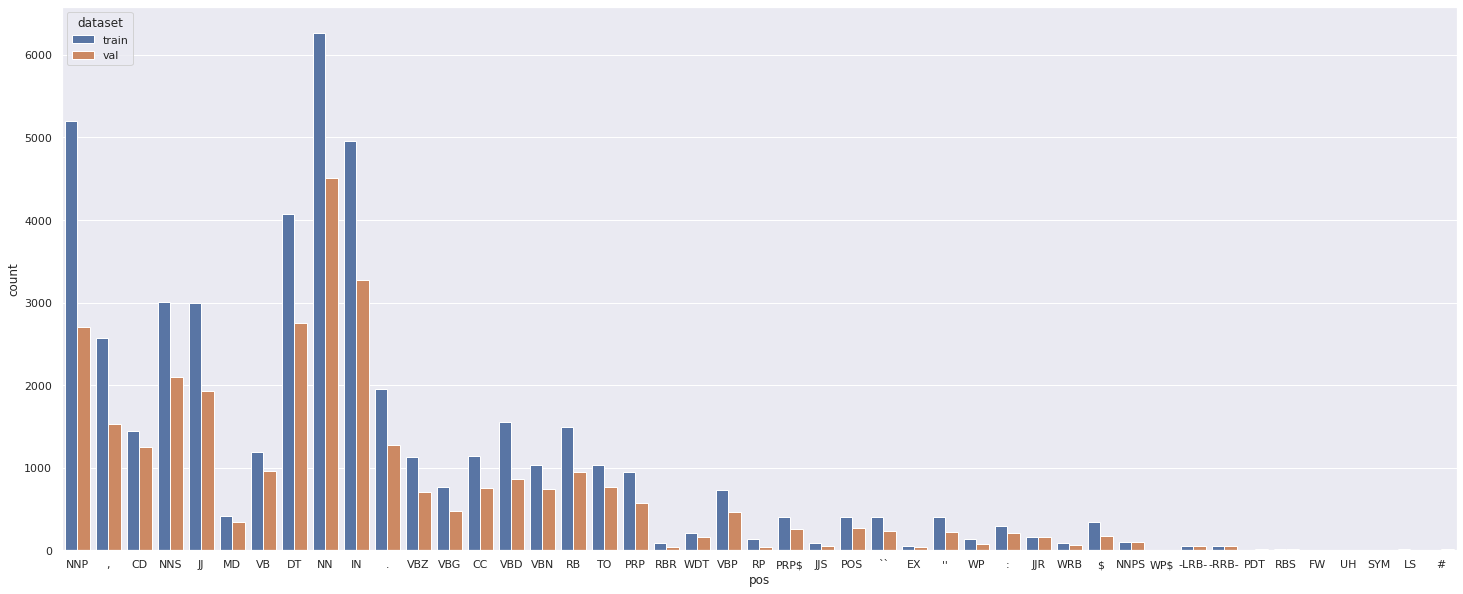

In [ ]:
# Plotting classes distribution in train and val
data_train = data['train'].explode('pos')
data_val = data['validation'].explode('pos')

concatenated = pd.concat([data_train.assign(dataset='train'), data_val.assign(dataset='val')])

_, ax = plt.subplots(figsize=(25, 10))
sns.countplot(x='pos', data=concatenated, hue='dataset', ax=ax)

plt.show()

We can clearly see that the classes are unevenly distributed in each set.

#### Checking OOV terms

Next, we will check how many terms in the train set are not present in the GloVe's vocabulary.
We are also going to plot the OOVs ordered according to their frequencies in the train set.

In [ ]:
# Getting the OOVs
def get_oov_list(vocabulary, words_in_data):
    """
    Compute list of the OOV words present in your data,
    given the vocabulary.

    Parameters
    ----------
    vocabulary: list
        All the words in your vocabulary.
    words_in_data: list
        All the words that occour at least once in your data
    
    Returns
    -------
    list
        requested out-of-vocabulary words
    """
    embedding_vocabulary = set(vocabulary)
    oov = set(words_in_data).difference(embedding_vocabulary)
    return list(oov)

train_vocab = X_train.explode().drop_duplicates().to_list()

oovs = get_oov_list(gloves.index_to_key, train_vocab)
print('The number of OOV in the training set is', len(oovs))

The number of OOV in the training set is 2346


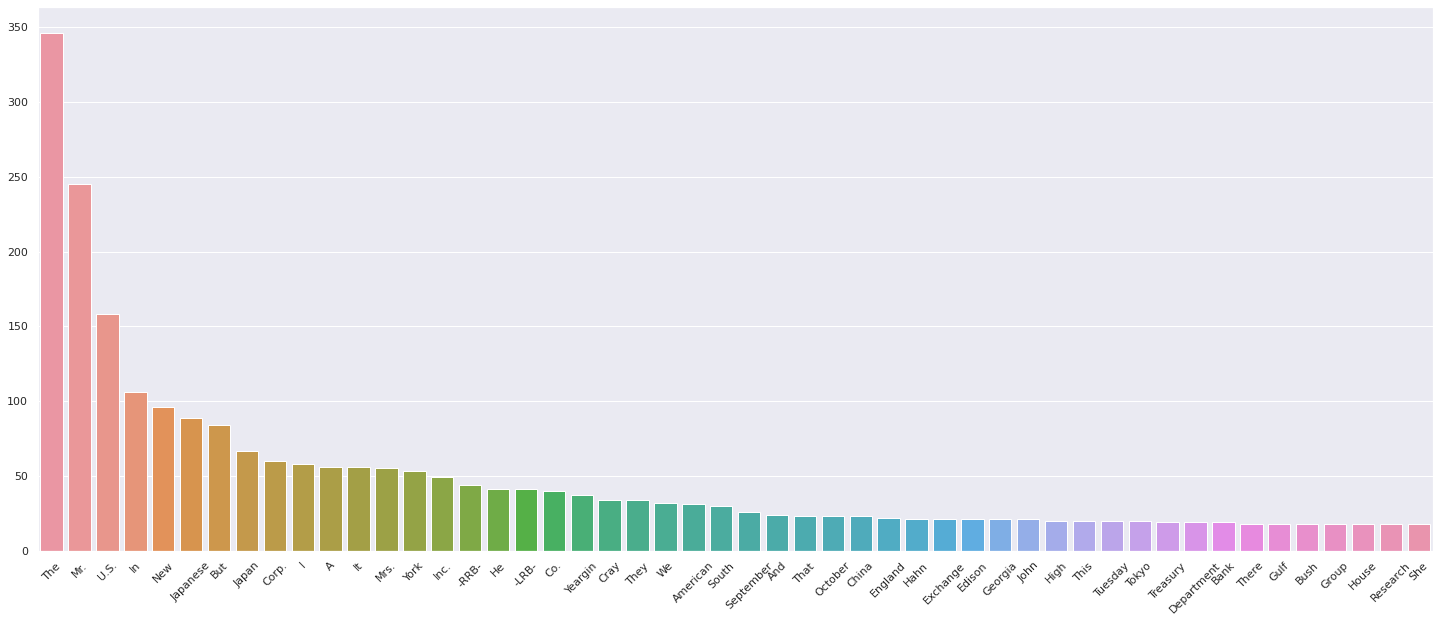

In [ ]:
# Plotting the 50 most frequent OOVs
oov_occurrence = X_train.explode()[X_train.explode().isin(oovs)]
oov_occurrence = oov_occurrence.value_counts()[:50]
_, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x=oov_occurrence.keys(), y=oov_occurrence.values, ax=ax)
plt.xticks(rotation=45)
plt.show()

The above results shows that a lot of OOV words are simply the title-case version of very common english words like "The" and "Mr.", thus we decided to turn all the input words in lower-case in order to reduce the number of OOV words with respect to the GloVe vocabulary.

In [ ]:
# Getting the OOVs again but after lowercasing
X_train_low = X_train.apply(lambda x: [word.lower() for word in x])
train_vocab = X_train_low.explode().to_list()
oovs = get_oov_list(gloves.index_to_key, train_vocab)

print('The number of OOV in the training set is', len(oovs))

The number of OOV in the training set is 359


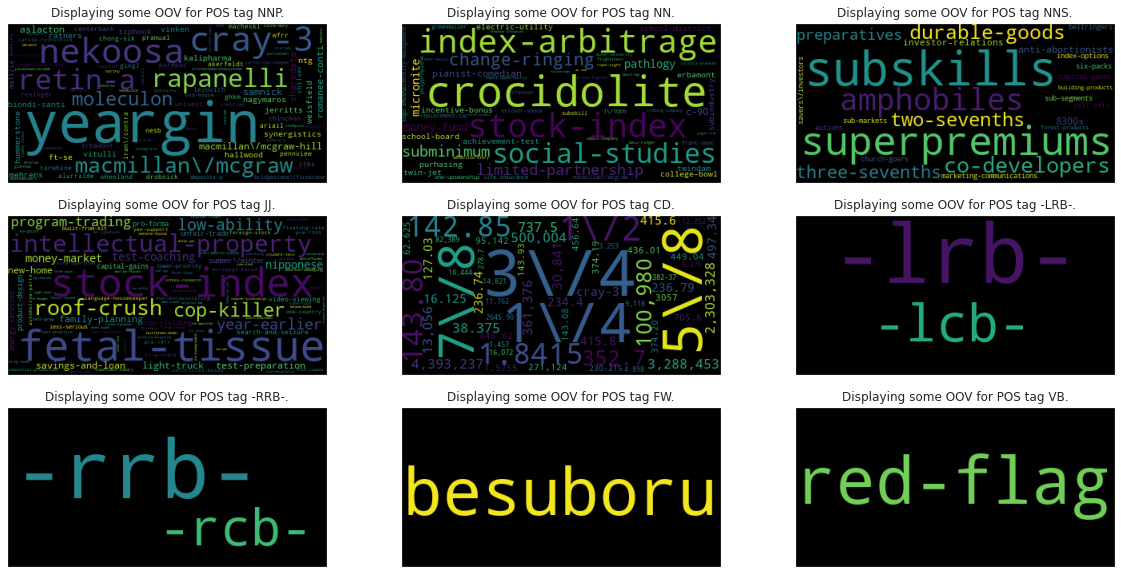

In [ ]:
X_data = data['train'].apply(pd.Series.explode)
X_data['sentence'] = X_data['sentence'].str.lower()
X_data['oov'] = X_data['sentence'].apply(lambda x: 1 if x in oovs else 0)

interesting_pos = X_data[X_data['oov'] == 1]['pos'].drop_duplicates()

_, axes = plt.subplots(3, len(interesting_pos) // 3, figsize=(20, 10))
for pos_tag, ax in zip(interesting_pos, axes.ravel()):
    words = X_data[(X_data['pos'] == pos_tag) & (X_data['oov'] == 1)]['sentence']
    figure = wordcloud.WordCloud(include_numbers=True, regexp='\S+', collocations=False).generate(' '.join(words))
    ax.set_title('Displaying some OOV for POS tag ' + pos_tag + '.')
    ax.grid(False)
    ax.imshow(figure)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

The number of OOVs in the training set is hugely decreased, let's plot them

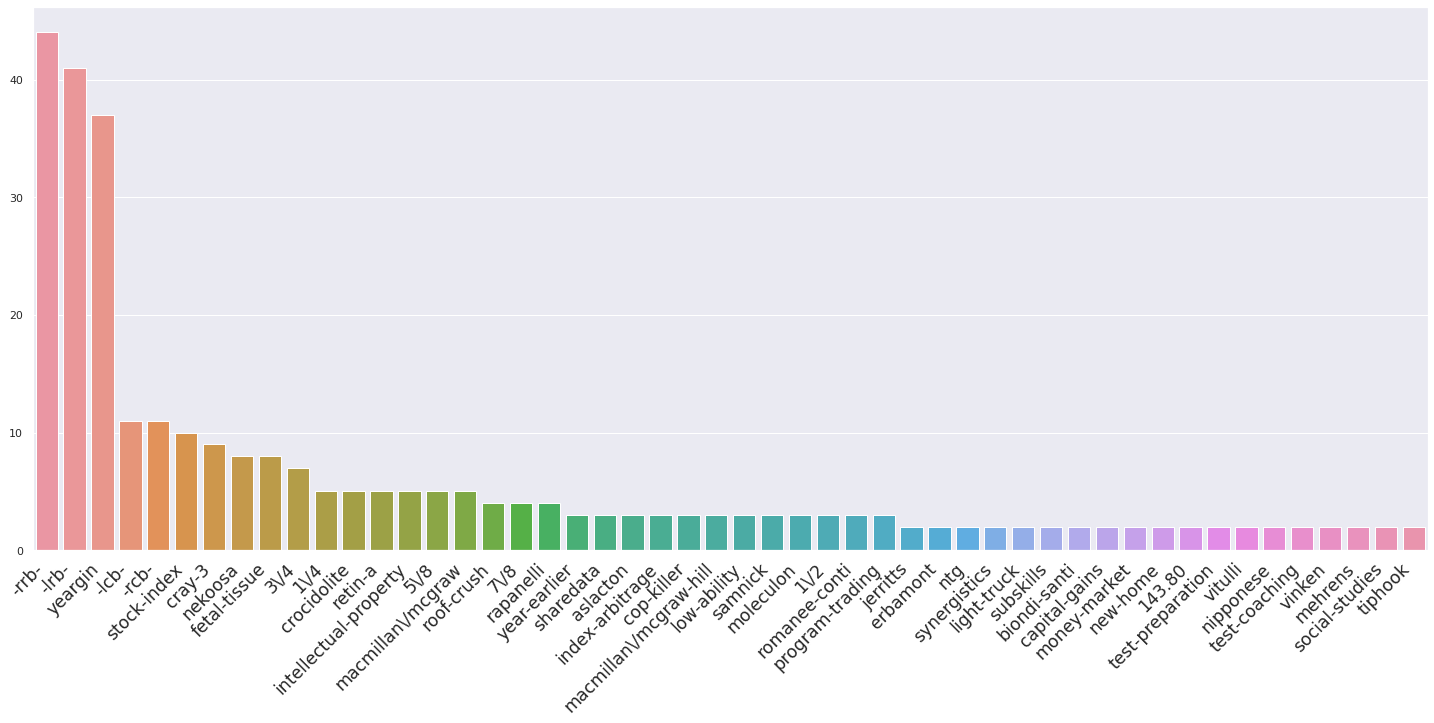

In [ ]:
# Plotting the 50 most frequent OOVs
oov_occurrence = X_train_low.explode()[X_train_low.explode().isin(oovs)]
oov_occurrence = oov_occurrence.value_counts()[:50]
_, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x=oov_occurrence.keys(), y=oov_occurrence.values, ax=ax)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

Now the plot shows that:


1. Brackets are expressed in another notation (e.g. -rrb-, -lrb- ...)
2. There are floating point numbers that could be replaced by a placeholder
3. There is a "typo", <code>\\/</code> should be just <code>/</code>

Also, some words that are in the dictionary, are separated by the character <code>-</code>, resulting as OOV word.

Let's now try to apply some preprocessing, taking into account the above considerations.

In [ ]:
float_re = re.compile('(\d*\,)?\d+\.\d*')
replace_lb = re.compile('(-lrb-)|(-lcb-)') 
replace_rb = re.compile('(-rrb-)|(-rcb-)')
replace_back = re.compile('(\\\/)')
def preprocess_text(text):
    """
    Perform text pre-processing according to the regular 
    expressions defined above.

    Parameters
    ----------
    text: list of string
        words to pre-process
    
    Returns
    -------
    list
        pre-processed input words
    """
    result = []
    for token in text:
        token = token.lower()
        token = '<float>' if re.match(float_re, token) else token
        token = replace_lb.sub('(', token)
        token = replace_rb.sub(')', token)
        token = replace_back.sub('-', token)
        result.append(token)
    return result

X_train_pre = X_train.apply(preprocess_text)

In [ ]:
train_vocab = X_train_pre.explode().drop_duplicates().to_list()
oovs = get_oov_list(gloves.index_to_key, train_vocab)
print('The number of OOV in the training set is', len(oovs))

The number of OOV in the training set is 319


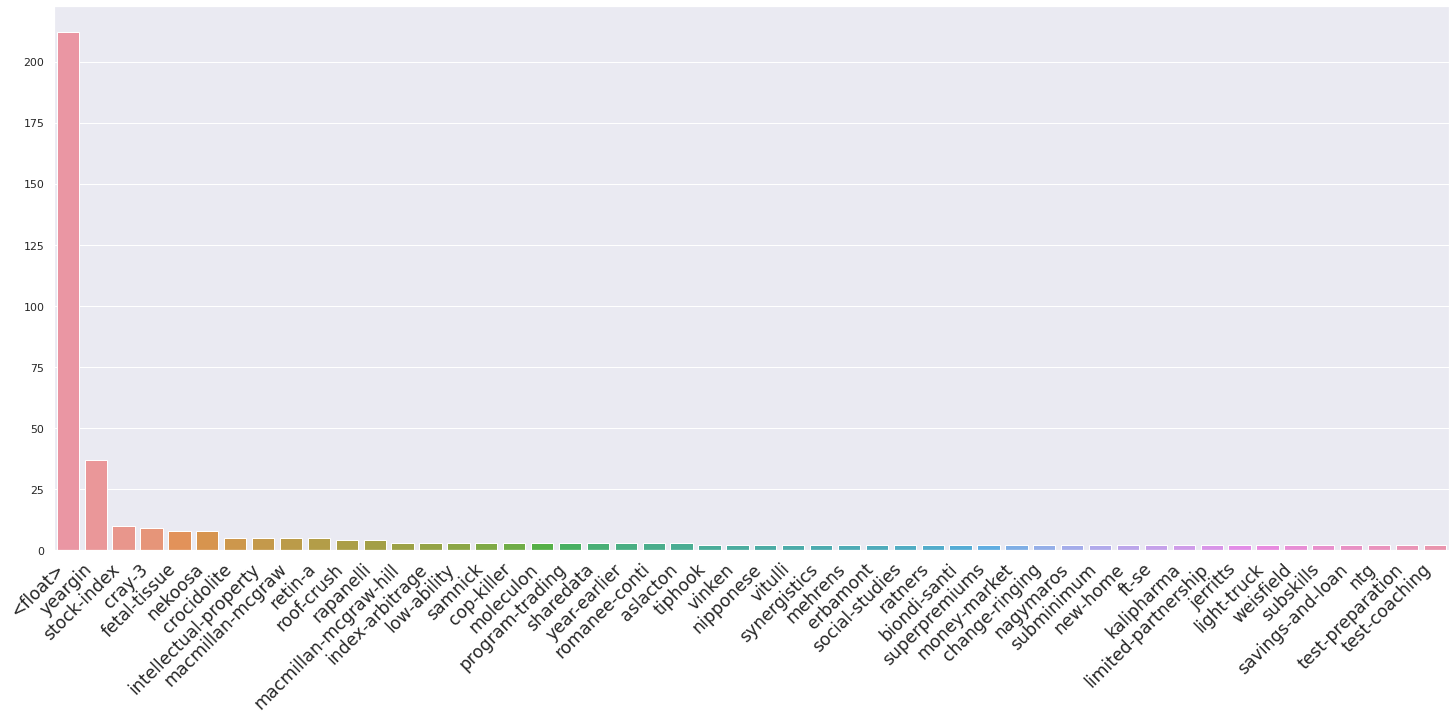

In [ ]:
oov_occurrence = X_train_pre.explode()[X_train_pre.explode().isin(oovs)]
oov_occurrence = oov_occurrence.value_counts()[:50]
_, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x=oov_occurrence.keys(), y=oov_occurrence.values, ax=ax)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

As we can clearly see, the most common OOV words (excluding the <code>\<float\></code> we just introduced) are now either compund words (i.e: composed of two or more other words separated by a dash) or proper nouns. Since it's quite reasonable for them not to be included in the GloVe vocabulary, we decided to conclude here the preprocessing step.

The training set has a percentage of OOV words equal to 4.42%


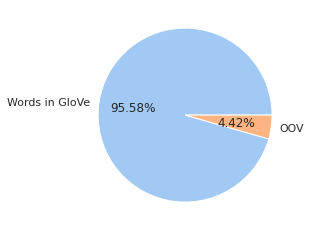

In [ ]:
# Define data for pie chart
oov_percentage = len(oovs)/len(train_vocab) * 100
print('The training set has a percentage of OOV words equal to {:.2f}%'.format(oov_percentage))
percentages = [100-oov_percentage, oov_percentage]
labels = ['Words in GloVe', 'OOV',]

# Define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:2]

# Create pie chart
plt.pie(percentages, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

### Create numeric mappings for sentences and POS tags

We are now going to create the word/token vocabulary using our custom <code>Sequencer</code> class. This class will also allow us to transform all the sentences in sequences, according to the vocabulary. The vocabulary creation follows the order of arrival of the list of tokens passed as argument to the <code>update_vocabulary</code> method, so that we achieve a deterministic behaviour for the OOV handling part.

Initially, we will add the OOVs only of the train set, in order to show that the OOV handling is separated for each set.

We're also going to use that same class in order to create a numerical mapping for the POS tags.


In [ ]:
# Applying preprocessing to validation and test sets
X_val_pre = X_val.apply(preprocess_text)
X_test_pre = X_test.apply(preprocess_text)

In [ ]:
class Sequencer:
  def __init__(self, initial_vocab=None):
    """
    Transform a set of sentences in a set of sequences and viceversa with a deterministic behaviour.
    The order of enumeration respects the order of the set of sentences used in the fit_on_texts method.
    """
    self.word_index = {}
    self.idx_to_word = {}
    self.__idx = 1
    if initial_vocab:
      self.update_vocabulary(initial_vocab)

  def update_vocabulary(self, texts):
    """
    Create/Update the vocabulary by looking at the list of sentences in input

    Parameters
    ----------
    texts: list
        List of sentences
    """
    for text in texts:
      for token in text:
        if token not in self.word_index:
          self.word_index[token] = self.__idx
          self.idx_to_word[self.__idx] = token
          self.__idx += 1

  def texts_to_sequences(self, texts):
    """
    Transform a list of sentences in a list of sequences, according to the current vocabulary

    Parameters
    ----------
    texts: list
        List of sentences
    """
    sequences = []
    for text in texts:
      sequence = []
      for token in text:
        sequence.append(self.word_index[token])
      sequences.append(sequence)
    return sequences

  def sequences_to_texts(self, sequences):
    """
    Transform a list of sequences in a list of sentences, according to the current vocabulary

    Parameters
    ----------
    sequences: list
        List of sequences
    """
    texts = []
    for seq in sequences:
      text = []
      for idx in seq:
        text.append(self.idx_to_word[idx])
      texts.append(text)
    return texts

In [ ]:
# Initializing vocabulary using the GloVe's keys
word_seq = Sequencer(initial_vocab=[gloves.key_to_index.keys()])

# Fitting the data
word_seq.update_vocabulary(X_train_pre)

# Fitting POS
pos_seq = Sequencer()
pos_seq.update_vocabulary(y_train)
pos_seq.update_vocabulary(y_val)
pos_seq.update_vocabulary(y_test)

# Text sequences -> Numerical sequences

X_train_encoded = word_seq.texts_to_sequences(X_train_pre)

y_train_encoded = pos_seq.texts_to_sequences(y_train)
y_val_encoded = pos_seq.texts_to_sequences(y_val)
y_test_encoded = pos_seq.texts_to_sequences(y_test)

# Getting the number of different POS tags
num_classes = len(pos_seq.word_index)

In [ ]:
print("X: ", X_train_pre[0])
print("X Encoded: ", X_train_encoded[0], '\n\n', 630*'=', '\n')
print("Y: ", y_train[0])
print("Y Encoded", y_train_encoded[0])

X:  ['pierre', 'vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', '29', '.']
X Encoded:  [5030, 400001, 2, 4979, 83, 168, 2, 44, 1430, 1, 535, 20, 8, 128565, 370, 2344, 1264, 3] 


Y:  ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']
Y Encoded [1, 1, 2, 3, 4, 5, 2, 6, 7, 8, 9, 10, 8, 5, 9, 1, 3, 11]


### Generate Embedding Matrix

Here we generate our embedding matrix. In particular, we decide to keep all the pre-computed vectors present in the GloVe model, as opposed to discarding those that do not appear in our dataset.

Since we noticed that many of the OOVs present in the train data are simply compund words (i.e.: they are made of two or more sub-words, concatenated using a dash), we compute their embedding as the average of the GloVe vectors for their sub-words.

Finally, for every other OOV in our dataset, we generate the embeddings in a random way, drawing them from a uniform distrubution. 

Note that we will build an initial embedding matrix, using the <code>build_embedding_matrix</code> method, based just on the vocabulary that includes the GloVe's keys and the OOVs of the training set; then we will update the embedding matrix by calling the <code>update_embedding_matrix</code> method on both the validation and test updated dictionaries. We remark that this choice is motivated by the OOV words separability criterion.

In [ ]:
class EmbeddingMatrixBuilder():

    def __init__(self):
        self.vocab_comp = {}

    def get_embedding_compound_word(self, word_parts, embeddings, embedding_size):
        """
        Compute embedding of a compound word as the average of the vectors 
        of its subwords. 

        Parameters
        ----------
        word_parts: list of string
            Subwords present in the original compound word
        embeddings: gensim.model.keyedvectors
            GloVe embeddings of the given size
        vocab_comp: dict
            Embeddings assigned to OOV subwords we already encountered before
        embedding_size: {50, 100, 200, 300}
            Size of the embedding vectors to be generated. Note that it must
            match the size of the GloVe embeddings

        Returns
        -------
        numpy.ndarray
            embedding vector for the compund word
        """
        comp_embedding = []
        for word in word_parts:
            try:
                embedding_vector = embeddings[word]
            except (KeyError, TypeError):
                if word not in self.vocab_comp:
                    embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_size)
                    self.vocab_comp[word] = embedding_vector
                else:
                    embedding_vector = self.vocab_comp[word]
            comp_embedding.append(embedding_vector)
        return np.mean(np.array(comp_embedding), axis=0)

    def build_embedding_matrix(self, embeddings, embedding_size, word_to_idx):
        """
        Build embedding matrix that will be used for the Keras Embedding 
        layer. 

        Parameters
        ----------
        embeddings: gensim.models.keyedvectors
            GloVe embeddings of the given size
        embedding_size: {50, 100, 200, 300}
            Size of the embedding vectors to be generated. Note that it must
            match the size of the GloVe embeddings
        word_to_idx: dict
            Mapping between each word in our vocabulary and a number
        
        Returns
        -------
        numpy.ndarray
            matrix containing the embedding of every word in our vocabulary
        """
        vocab_size = len(word_to_idx.keys()) + 1 
        embedding_matrix = np.zeros(
            (vocab_size, embedding_size), 
            dtype=np.float32)

        for word, idx in tqdm(
            word_to_idx.items(), 
            desc='Building embedding matrix..'):
            try:
                embedding_vector = embeddings[word]
            except (KeyError, TypeError):
                if '-' in word:
                    word_parts = word.split('-')
                    embedding_vector = self.get_embedding_compound_word(word_parts, embeddings, embedding_size)
                else:
                    embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_size)

            embedding_matrix[idx] = embedding_vector
        return embedding_matrix
    
    def update_embedding_matrix(self, embedding_matrix, embeddings, word_to_idx):
        """
        Update embedding_matrix with the new OOV words present on word_to_idx 

        Parameters
        ----------
        embedding_matrix: numpy.ndarray
            The initial embedding matrix
        embeddings: gensim.models.keyedvectors
            GloVe embeddings of the given size
        word_to_idx: dict
            Mapping between each word in our vocabulary and a number
        
        Returns
        -------
        numpy.ndarray
            The updated embedding matrix
        """
        new_embeddings = []
        embedding_size = embedding_matrix.shape[1]
        for word, idx in tqdm(
            list(word_to_idx.items())[embedding_matrix.shape[0]:], 
            desc='Updating embedding matrix..'):

            try:
                embedding_vector = embeddings[word]
            except (KeyError, TypeError):
                if '-' in word:
                    word_parts = word.split('-')
                    embedding_vector = self.get_embedding_compound_word(word_parts, embeddings, embedding_size)
                else:
                    embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_size)
            new_embeddings.append(embedding_vector)
        if len(new_embeddings) == 0:
            new_embedding_matrix = embedding_matrix
        else:
            new_embedding_matrix = np.concatenate((embedding_matrix, np.array(new_embeddings)), axis=0)
        return new_embedding_matrix
           

In [ ]:
# Our vocabulary is in word_tok
print(len(word_seq.word_index.keys()))
emb = EmbeddingMatrixBuilder()
embeddings = emb.build_embedding_matrix(gloves, 50, word_seq.word_index)

400319


Building embedding matrix..: 100%|██████████| 400319/400319 [00:01<00:00, 355804.27it/s]


In [ ]:
word_seq.update_vocabulary(X_val_pre)
X_val_encoded = word_seq.texts_to_sequences(X_val_pre)
print(len(word_seq.word_index.keys()))
embeddings = emb.update_embedding_matrix(embeddings, gloves, word_seq.word_index)

word_seq.update_vocabulary(X_test_pre)
X_test_encoded = word_seq.texts_to_sequences(X_test_pre)
print(len(word_seq.word_index.keys()))

embeddings = emb.update_embedding_matrix(embeddings, gloves, word_seq.word_index)

400479


Updating embedding matrix..: 100%|██████████| 159/159 [00:00<00:00, 14990.43it/s]


400575


Updating embedding matrix..: 100%|██████████| 96/96 [00:00<00:00, 20936.63it/s]


### Sanity Checks

To assure that everything done untill now is correct, let's run some "sanity checks". In particular we'll check that:
1.  No word is encoded with the number 0 (which is reserved for padding)
2.  We have exactly <code>num_classes</code> different POS tags in all the sets

In [ ]:
# 1
for sentence in X_train_encoded:
    assert 0 not in sentence

# 2
pos_nd = []
for pos in [*y_train.to_list(), *y_test.to_list() , *y_val.to_list()]:
    pos_nd += pos
assert len(set(pos_nd)) == num_classes

### Pad sequences

Next, we will pad the sentences and the classes encoded before. 
This is necessary because we need each sentence to have the same length in each batch during training.
The pad values will be masked out and discarded during the training.

In [ ]:
MAX_SEQ_LENGHT_TRAIN = max([len(x) for x in X_train_encoded])
MAX_SEQ_LENGHT_VAL = max([len(x) for x in X_val_encoded])
MAX_SEQ_LENGHT_TEST = max([len(x) for x in X_test_encoded])

X_train_padded = pad_sequences(
    X_train_encoded, 
    maxlen=MAX_SEQ_LENGHT_TRAIN, 
    padding='post')
X_val_padded = pad_sequences(
    X_val_encoded, 
    maxlen=MAX_SEQ_LENGHT_VAL, 
    padding='post')
X_test_padded = pad_sequences(
    X_test_encoded, 
    maxlen=MAX_SEQ_LENGHT_TEST, 
    padding='post')
y_train_padded = pad_sequences(
    y_train_encoded, 
    maxlen=MAX_SEQ_LENGHT_TRAIN, 
    padding='post')
y_val_padded = pad_sequences(
    y_val_encoded, 
    maxlen=MAX_SEQ_LENGHT_VAL, 
    padding='post')
y_test_padded = pad_sequences(
    y_test_encoded, 
    maxlen=MAX_SEQ_LENGHT_TEST, 
    padding='post')

Let's use OneHotEncoding on the padded classes

In [ ]:
# One-hot encode the y values
from tensorflow.keras.utils import to_categorical

y_train_hot = to_categorical(y_train_padded, num_classes=num_classes+1)

y_val_hot = to_categorical(y_val_padded, num_classes=num_classes+1)

y_test_hot = to_categorical(y_test_padded, num_classes=num_classes+1)


y_val_hot.shape

(1299, 81, 46)

In [ ]:
print("X: ", X_train_encoded[0])
print("X Encoded: ", X_train_padded[0], '\n\n', 100*'=', '\n')
print("Y: ", y_train_encoded[0])
print("Y Encoded:", y_train_padded[0])

X:  [5030, 400001, 2, 4979, 83, 168, 2, 44, 1430, 1, 535, 20, 8, 128565, 370, 2344, 1264, 3]
X Encoded:  [  5030 400001      2   4979     83    168      2     44   1430      1
    535     20      8 128565    370   2344   1264      3      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0 

### Defining the model

The following method will return a Keras model, defined by the input parameters.

The embedding matrix contains also all the OOV words of the validation and test set, but they will not influence the training of the model.

In [ ]:
def get_model(input_dim, 
                 num_classes, 
                 embeddings, 
                 name = 'baseline',
                 use_GRU = False, 
                 additional_LSTM = False, 
                 additional_dense = False,
                 units=100,
                 dropout=0.0):
  """
  Create a Keras model for the POS-tagging task

  Parameters
  ----------
  input_dim: int
      The vocabulary size
  num_classes: int
      The number of different POS-tags (+ a class for the padding value) to be predicted 
  embeddings: numpy.ndarray
      Matrix containing the pre-trained embeddings 
  name: str
      The name of the model
  use_GRU: bool
      If True, use a BiGRU layer instead of the BiLSTM
  additional_LSTM: bool
      If True, use an additional BiLSTM layer right after the default one
  additional_dense: bool
      If True, adds a FC layer before the classifier
  units: int
      The hidden state's dimension of the RNNs
  dropout: float
      Define the drop rate of the Dropout layers. By default the dropout is disabled

  Returns
  -------
  tensorflow.keras.models.Model
      The POS-tagging model
      
  """
  inputs = Input(shape=(None,), dtype="int32")
  x = Embedding(
      input_dim=input_dim, 
      output_dim=embeddings.shape[1],
      mask_zero=True, 
      weights=[embeddings], 
      trainable=False)(inputs)
  if dropout:
    x = Dropout(dropout)(x)
  if use_GRU:
    rnn = GRU(units=units, return_sequences=True)
  else:
    rnn = LSTM(units=units, return_sequences=True, dropout=dropout)
  x = Bidirectional(rnn)(x)
  if additional_LSTM:
    x = LSTM(units=units, return_sequences=True)(x)
  if additional_dense:
    x = Dense(100, activation='relu')(x)
  x = Dense(num_classes, activation='softmax')(x)
  return Model(inputs, x, name=name)

### Defining Model Evaluations

Now we will define two methods for the evaluation of the models

In [ ]:
# Plot the loss and the accuracy scores on the training and validation s
def plot_loss_accuracy_f1(histories):
  """
  Plot loss and accuracy achieved during training for train and
  validation sets, starting from a dictionary of their values.

  Parameters
  ----------
  history: dict
      Loss and accuracy values at each epoch of the training phase.
  """
  figsize = 16
  _, axes = plt.subplots(nrows=len(histories), ncols=3, figsize=(figsize, 4*len(histories)))
  for idx, name in enumerate(histories.keys()):
    history = histories[name].history
    steps = len(history['loss'])
    early_stop = steps - 6

    data_loss = pd.DataFrame(np.array([history['loss'], history['val_loss']]).T, columns=['train', 'val'])
    data_accuracy = pd.DataFrame(np.array([history['accuracy'], history['val_accuracy']]).T, columns=['train', 'val'])
    data_f1 = pd.DataFrame(np.array(history['val_f1']), columns=['f1'])
    
    ax = axes[idx].ravel() if type(axes[idx]) is np.ndarray else axes
    sns.lineplot(data=data_loss, ax=ax[0])
    sns.lineplot(data=data_accuracy, ax=ax[1])
    sns.lineplot(data=data_f1, ax=ax[2])
    
    ax[0].axvline(early_stop, color='red', linestyle='--')
    ax[1].axvline(early_stop, color='red', linestyle='--')
    ax[2].axvline(early_stop, color='red', linestyle='--')

    ax[0].set_xlabel('epoch')
    ax[1].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[1].set_ylabel('accuracy')
    ax[0].set_title(name + ' loss')
    ax[1].set_title(name + ' accuracy')

  plt.tight_layout()  
  plt.show()

In [ ]:
# Evaluation on test set
def get_filtered_predictions(y_true_hot, y_pred_hot, filters):
    """
    Filter our the predictions for the padding class and for 
    punctuation/symbols, which we do not want to include in the
    final evaluation.

    Parameters
    ----------
    y_true_hot: numpy.ndarray
        Ground truth y values one hot encoded
    y_pred_hot: numpy.ndarray
        Y values predicted by our model
    filters: list
        Numeric encoding of the classes to filter out
    
    Returns
    -------
    numpy.ndarray
        Fileterd ground truth values
    numpy.ndarray
        Filtered predicted values.
    """
    y_true_flat = np.argmax(y_true_hot, axis=-1).flatten()
    y_pred_flat = np.argmax(y_pred_hot, axis=-1).flatten()
    
    pos_mask = np.array([y_true_flat == sym for sym in filters])
    pos_mask = ~np.sum(pos_mask, axis = 0, dtype='bool')
    return y_true_flat[pos_mask], y_pred_flat[pos_mask]

# Plot the confusion matrix given the predictions and the true results
def plot_confusion_matrix(y_true, y_pred, labels, display_labels, ax):
    """
    Plot confusion matrix for the given results.

    Parameters
    ----------
    y_true: numpy.ndarray
        Ground truth labels.
    y_pred: numpy.ndarray
        Labels predicted by our model
    labels: list
        Numeric encoding of the classes that we want to consider
        for the evaluation
    display_labels: list
        Labels that should appear as annotations in the plot
    """
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
        labels=labels, normalize='true', display_labels=display_labels, ax=ax, include_values=False,cmap=plt.cm.Blues)
    disp.im_.colorbar.remove()

# Evaluate the given model by means of f1 score taking into account the unwanted class
def evaluate_models(models, X, y_true, filters, plot=False):
    """
    Evaluate the F1 score of a given model on a dataset, while 
    not considering the classes specified in 'filters'. 
    If plot=True, display a confusion matrix.

    Parameters
    ----------
    model: tensorflow.keras.Model
        Model that we want to evaluate.
    X: numpy.ndarray
        Input features for our model.
    y_true: numpy.ndarray
        Ground truth labels.
    filters: list
        Numeric encoding of the classes that we do not want to consider
        for the evaluation
    plot: bool
        Whether to plot the confusion matrix or not
    
    Returns
    -------
    float:
        F1 score obtained by 'model' on the given dataset, only 
        considering the classes not in 'filters'.
    """

    f1 = []
    figsize = 24 if len(models) > 1 else 12
    
    
    fig, axes = plt.subplots((len(models) + 1) // 2, 2 if len(models) > 1 else 1, figsize=(figsize, figsize))
    axes = axes.ravel() if type(axes) is np.ndarray else [axes]
    for model, ax in zip(models, axes):
      ax.set_title(model.name)
      y_pred = model.predict(X, batch_size=64)
      y_true_filters, y_pred_filters = get_filtered_predictions(y_true, y_pred, filters)
      labels = []
      for pos in np.unique(y_true_filters):
          if pos not in filters:
              labels.append(pos)
      disp_labels = pos_seq.sequences_to_texts([labels])
      disp_labels=labels
      f1.append(f1_score(y_true_filters, y_pred_filters, average='macro', labels=labels, zero_division=0))
      if plot:
          plot_confusion_matrix(y_true_filters, y_pred_filters, labels, disp_labels, ax)

    fig, ax = plt.subplots(figsize=(figsize, 1))
    fig.subplots_adjust(bottom=0.5)
    cmap = plt.cm.Blues
    norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal')
    
    plt.show()
    return f1

# Defining the POS tags that should not contribute to the f1 score evaluation
pos_filters = [',', '.', '``', "''", ':', '$', '-LRB-', '-RRB-', '#', 'SYM']
pos_filters_enc = pos_seq.texts_to_sequences([pos_filters])[0]
pos_filters_enc.append(0)

#### Early Stopping criterion

We have defined an early stopping criterion based on the F1 score (average macro), so we stop training when the model reach his maximum F1 score on the validation set.

In order to implement this behaviour, we had to define the computation of the F1 score at the end of every epoch via a custom early stopping callback. The reason behind this choice is that, due to the batching of the data, the F1 score can not be defined as a Keras Metric. 

We decided not to use as stopping criterion the validation accuracy because the classes are unevely distributed.

In [ ]:
class EarlyStopByF1(Callback):
    def __init__(self, val_data, verbose = 0, patience=5, filters=[]):
        super(Callback, self).__init__()
        # Best_weights to store the weights at which the maximum F1 occurs.
        self.best_weights = None
        self.verbose = verbose
        self.patience = patience
        self.filters = filters
        self.X_val = val_data[0]
        self.y_val = val_data[1]
        self.stopped = 0

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # Initialize the best as infinity.
        self.best = 0

    def on_epoch_end(self, epoch, logs=None):
        predict = np.asarray(self.model.predict(self.X_val))
        y_true, y_pred = get_filtered_predictions(self.y_val, predict, self.filters)
        labels = []
        for pos in np.unique(y_true):
            if pos not in self.filters:
                labels.append(pos)
        disp_labels = pos_seq.sequences_to_texts([labels])
        disp_labels=labels
        f1 = f1_score(y_true, y_pred, average='macro', labels=labels, zero_division=0)
        logs['val_f1'] = f1
        
        if f1 < self.best:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped = epoch
                    
                self.model.stop_training = True
                self.model.set_weights(self.best_weights)
        else:
            self.best = f1
            self.wait = 0
            # Record the best weights if current results is better.
            self.best_weights = self.model.get_weights()
    
    def on_train_end(self, logs=None):
      if self.stopped:
        print("Epoch {}: early stopping triggered. restoring best weights.".format(self.stopped + 1))


### Building and training the models

We are goning to train the baseline model and all its variants, then in the end we will show the results of each one and compare them

####  Building the baseline RNN model

In [ ]:
batch_size = 8
epochs = 100
models = {}
histories = {}

In [ ]:
models['baseline'] = get_model(embeddings.shape[0], num_classes+1, embeddings)
models['baseline'].summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 50)          20028750  
                                                                 
 bidirectional (Bidirectiona  (None, None, 200)        120800    
 l)                                                              
                                                                 
 dense (Dense)               (None, None, 46)          9246      
                                                                 
Total params: 20,158,796
Trainable params: 130,046
Non-trainable params: 20,028,750
_________________________________________________________________


Now, let's fit the train set using a baseline RNN model.

In [ ]:
models['baseline'].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
histories['baseline'] = models['baseline'].fit(x=X_train_padded, 
                   y=y_train_hot, 
                   batch_size=batch_size, epochs=epochs, 
                   validation_data=(X_val_padded, y_val_hot),
                   callbacks=[EarlyStopByF1(val_data=(X_val_padded, y_val_hot), verbose=1, filters=pos_filters_enc)])

Epoch 1/100
246/246 [==============================] - 29s 69ms/step - loss: 0.1854 - accuracy: 0.5007 - val_loss: 0.3454 - val_accuracy: 0.6862 - val_f1: 0.3435
Epoch 2/100
246/246 [==============================] - 10s 41ms/step - loss: 0.0885 - accuracy: 0.7542 - val_loss: 0.2464 - val_accuracy: 0.7637 - val_f1: 0.4527
Epoch 3/100
246/246 [==============================] - 10s 40ms/step - loss: 0.0678 - accuracy: 0.8055 - val_loss: 0.2100 - val_accuracy: 0.7963 - val_f1: 0.5256
Epoch 4/100
246/246 [==============================] - 10s 41ms/step - loss: 0.0575 - accuracy: 0.8334 - val_loss: 0.1864 - val_accuracy: 0.8179 - val_f1: 0.5680
Epoch 5/100
246/246 [==============================] - 10s 40ms/step - loss: 0.0505 - accuracy: 0.8513 - val_loss: 0.1718 - val_accuracy: 0.8317 - val_f1: 0.5941
Epoch 6/100
246/246 [==============================] - 10s 40ms/step - loss: 0.0451 - accuracy: 0.8664 - val_loss: 0.1599 - val_accuracy: 0.8392 - val_f1: 0.6266
Epoch 7/100
246/246 [=======

#### Building the baseline model with an additional LSTM layer

In [ ]:
models['LSTM']= get_model(embeddings.shape[0], 
                          num_classes+1, 
                          embeddings, 
                          name='LSTM',
                          additional_LSTM=True)
models['LSTM'].summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 50)          20028750  
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 200)        120800    
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, None, 100)         120400    
                                                                 
 dense_1 (Dense)             (None, None, 46)          4646      
                                                                 
Total params: 20,274,596
Trainable params: 245,846
Non-trainable params: 20,028,750
____________________________________________

Now, let's fit the train set using a baseline model with an additional LSTM layer.

In [ ]:
models['LSTM'].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
histories['LSTM'] = models['LSTM'].fit(x=X_train_padded, 
                              y=y_train_hot, 
                              batch_size=batch_size, 
                              epochs=epochs, 
                              validation_data=(X_val_padded, y_val_hot),
                              callbacks=[EarlyStopByF1(val_data=(X_val_padded, y_val_hot), verbose=1, filters=pos_filters_enc)])

Epoch 1/100
246/246 [==============================] - 36s 93ms/step - loss: 0.2082 - accuracy: 0.4178 - val_loss: 0.4019 - val_accuracy: 0.6297 - val_f1: 0.2669
Epoch 2/100
246/246 [==============================] - 14s 57ms/step - loss: 0.0993 - accuracy: 0.7274 - val_loss: 0.2653 - val_accuracy: 0.7485 - val_f1: 0.3930
Epoch 3/100
246/246 [==============================] - 14s 56ms/step - loss: 0.0705 - accuracy: 0.8015 - val_loss: 0.2109 - val_accuracy: 0.7999 - val_f1: 0.4869
Epoch 4/100
246/246 [==============================] - 14s 57ms/step - loss: 0.0561 - accuracy: 0.8383 - val_loss: 0.1799 - val_accuracy: 0.8234 - val_f1: 0.5213
Epoch 5/100
246/246 [==============================] - 14s 57ms/step - loss: 0.0471 - accuracy: 0.8623 - val_loss: 0.1599 - val_accuracy: 0.8442 - val_f1: 0.5901
Epoch 6/100
246/246 [==============================] - 13s 54ms/step - loss: 0.0403 - accuracy: 0.8825 - val_loss: 0.1472 - val_accuracy: 0.8520 - val_f1: 0.6055
Epoch 7/100
246/246 [=======

####  Building baseline model with GRU layer

In [ ]:
models['GRU'] = get_model(embeddings.shape[0], 
                          num_classes+1, 
                          embeddings,
                          name='GRU',
                          use_GRU=True)
models['GRU'].summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 50)          20028750  
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 200)        91200     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, None, 46)          9246      
                                                                 
Total params: 20,129,196
Trainable params: 100,446
Non-trainable params: 20,028,750
_________________________________________________________________


Now,&nbsp;let's&nbsp;fit&nbsp;the&nbsp;train set&nbsp;using&nbsp;a&nbsp;baseline&nbsp;model with a GRU layer.

In [ ]:
models['GRU'].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
histories['GRU'] = models['GRU'].fit(x=X_train_padded, 
                              y=y_train_hot, 
                              batch_size=batch_size, 
                              epochs=epochs, 
                              validation_data=(X_val_padded, y_val_hot),
                              callbacks=[EarlyStopByF1(val_data=(X_val_padded, y_val_hot), verbose=1, filters=pos_filters_enc)])

Epoch 1/100
246/246 [==============================] - 25s 64ms/step - loss: 0.1532 - accuracy: 0.5894 - val_loss: 0.2743 - val_accuracy: 0.7420 - val_f1: 0.4283
Epoch 2/100
246/246 [==============================] - 9s 39ms/step - loss: 0.0713 - accuracy: 0.7936 - val_loss: 0.2081 - val_accuracy: 0.7940 - val_f1: 0.5411
Epoch 3/100
246/246 [==============================] - 9s 38ms/step - loss: 0.0562 - accuracy: 0.8324 - val_loss: 0.1817 - val_accuracy: 0.8196 - val_f1: 0.5786
Epoch 4/100
246/246 [==============================] - 9s 37ms/step - loss: 0.0476 - accuracy: 0.8580 - val_loss: 0.1623 - val_accuracy: 0.8371 - val_f1: 0.6239
Epoch 5/100
246/246 [==============================] - 9s 38ms/step - loss: 0.0413 - accuracy: 0.8758 - val_loss: 0.1489 - val_accuracy: 0.8512 - val_f1: 0.6521
Epoch 6/100
246/246 [==============================] - 9s 38ms/step - loss: 0.0362 - accuracy: 0.8917 - val_loss: 0.1393 - val_accuracy: 0.8566 - val_f1: 0.6846
Epoch 7/100
246/246 [============

#### Building baseline model with an additional Dense layer

In [ ]:
models['dense'] = get_model(embeddings.shape[0], 
                           num_classes+1, 
                           embeddings, 
                           name='dense',
                           additional_dense=True)
models['dense'].summary()

Model: "dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 50)          20028750  
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 200)        120800    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, None, 100)         20100     
                                                                 
 dense_4 (Dense)             (None, None, 46)          4646      
                                                                 
Total params: 20,174,296
Trainable params: 145,546
Non-trainable params: 20,028,750
___________________________________________

Now let's train the baseline model with an additional Dense layer.

In [ ]:
models['dense'].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
histories['dense'] = models['dense'].fit(x=X_train_padded, 
                              y=y_train_hot, 
                              batch_size=batch_size, 
                              epochs=epochs, 
                              validation_data=(X_val_padded, y_val_hot),
                              callbacks=[EarlyStopByF1(val_data=(X_val_padded, y_val_hot), verbose=1, filters=pos_filters_enc)])

Epoch 1/100
246/246 [==============================] - 27s 69ms/step - loss: 0.1738 - accuracy: 0.5184 - val_loss: 0.2985 - val_accuracy: 0.7208 - val_f1: 0.3723
Epoch 2/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0762 - accuracy: 0.7776 - val_loss: 0.2176 - val_accuracy: 0.7817 - val_f1: 0.4660
Epoch 3/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0578 - accuracy: 0.8261 - val_loss: 0.1877 - val_accuracy: 0.8105 - val_f1: 0.5521
Epoch 4/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0476 - accuracy: 0.8533 - val_loss: 0.1607 - val_accuracy: 0.8363 - val_f1: 0.5935
Epoch 5/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0406 - accuracy: 0.8754 - val_loss: 0.1453 - val_accuracy: 0.8535 - val_f1: 0.6485
Epoch 6/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0353 - accuracy: 0.8938 - val_loss: 0.1361 - val_accuracy: 0.8603 - val_f1: 0.6881
Epoch 7/100
246/246 [=======

### Showing the results for each model

Finally, we'll use the methods defined above in order to plot F1 score, accuracy and loss for our 4 models. Note that we also show with a red vertical line the best epoch according to the Early Stopping criterion.

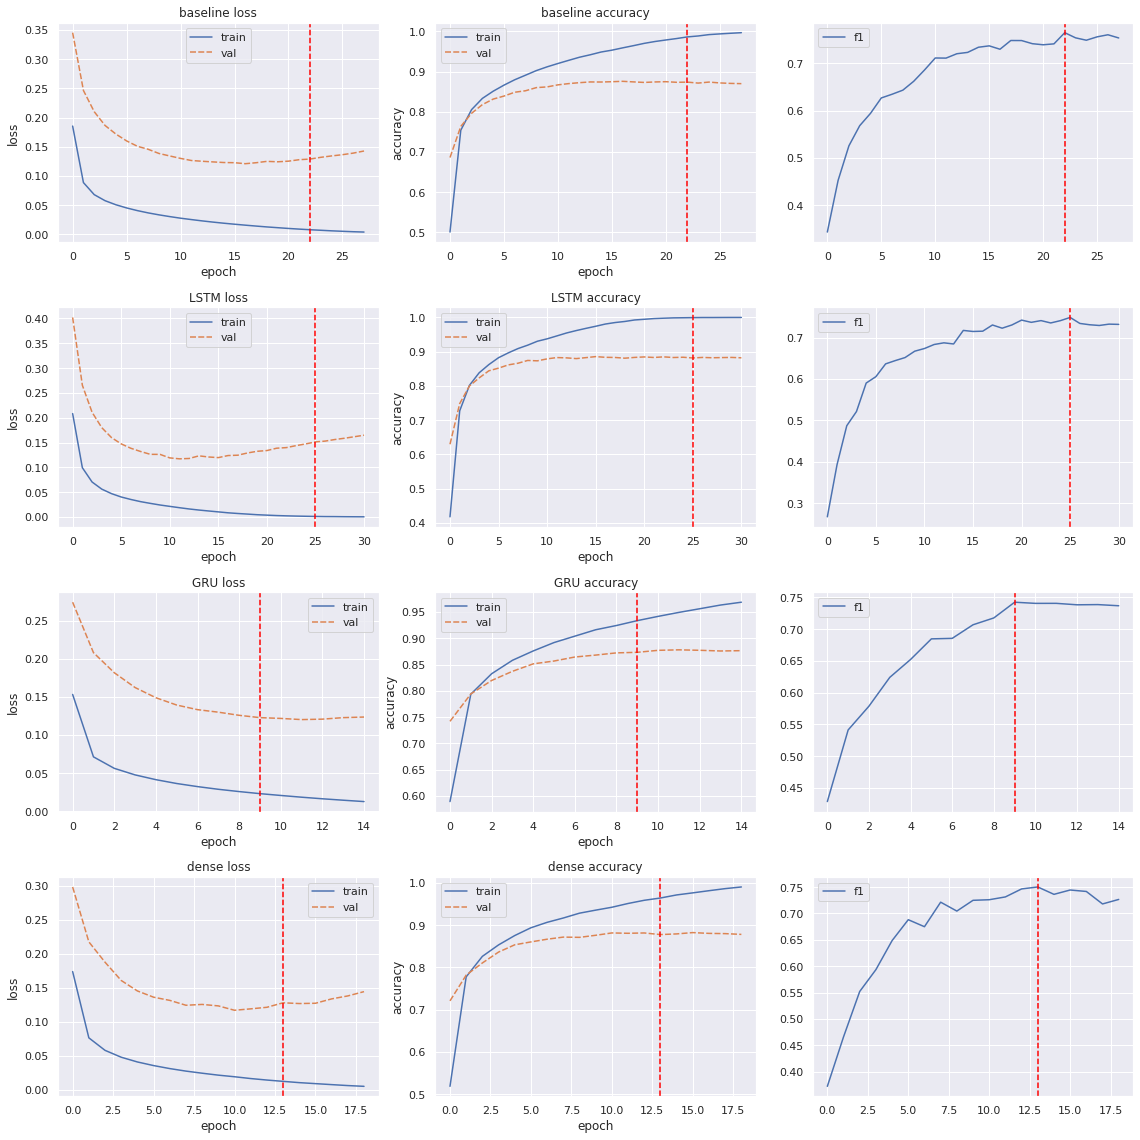

In [ ]:
plot_loss_accuracy_f1(histories)

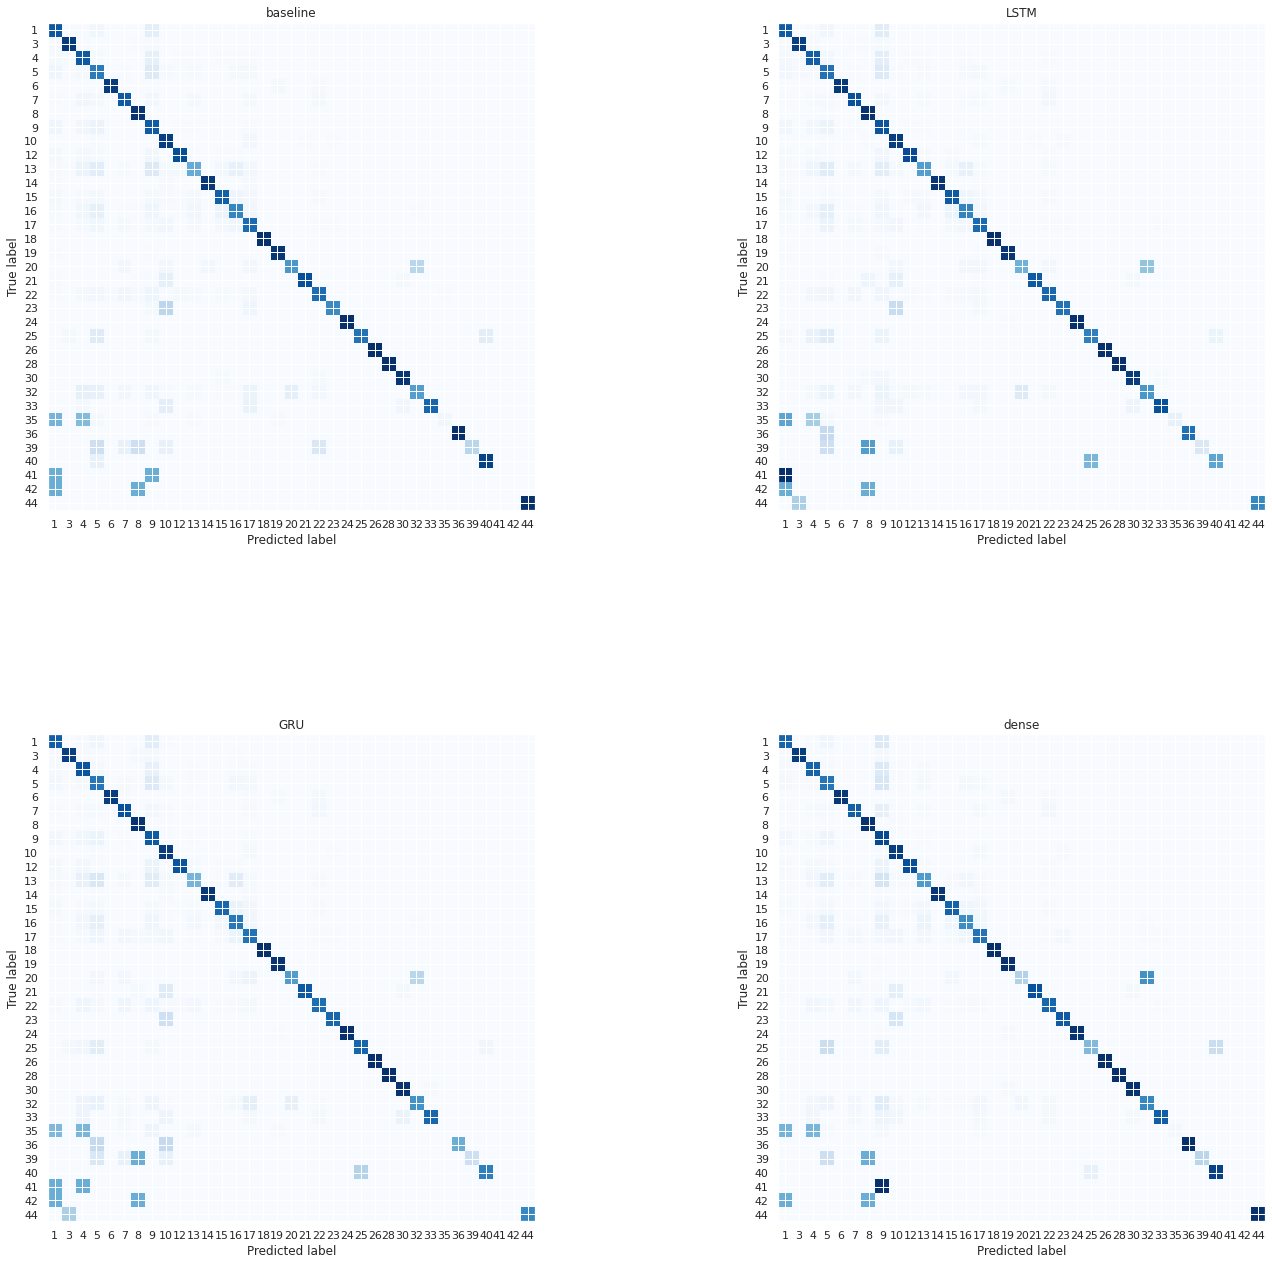

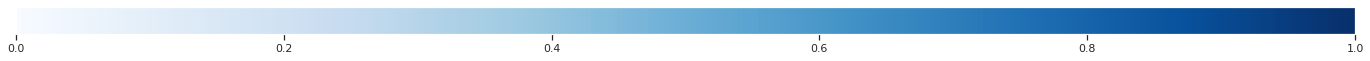

In [ ]:
f1_scores = evaluate_models(list(models.values()), X_val_padded, y_val_hot, pos_filters_enc, plot=True)

Let's now compare the F1 score of each model and then select the two best performing.

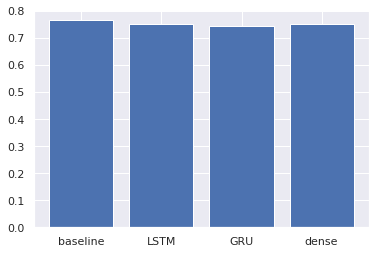

In [ ]:
plt.bar(x=histories.keys(), height=f1_scores);

In [ ]:
best_models = []
for i in np.argsort(f1_scores)[2:]:
  best_models.append(list(models.values())[i])
print('The best models, w.r.t. f1 score (average macro) are: \n\t{}\n\t{}'.format(best_models[0].name, best_models[1].name))

The best models, w.r.t. f1 score (average macro) are: 
	dense
	baseline


#### Discussing results

By looking at the results, we can see that they are very similar by means of accuracy and F1 score. Some models tends to overfit early, like the one with an additional BiLSTM, but in the end the results on the two metrics (validation accuracy and F1 score) are still very similar to the others. 

As we can see from the confusion matricces, all the models have issues on two particular classes, in particular FW and UH.
It is plausible that, the lack of data that contains those classes and the high probability of the words associated with those classes to be OOV, are the causes of the issue.

Let's now see the results on the test set of the two best performing model by means of validation's F1 score.

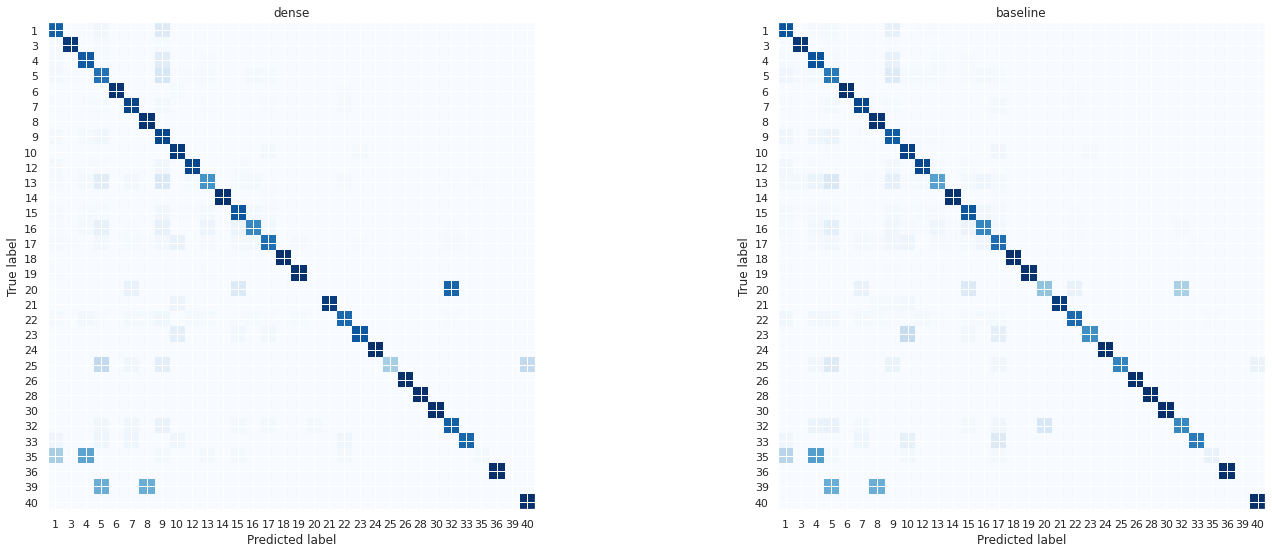

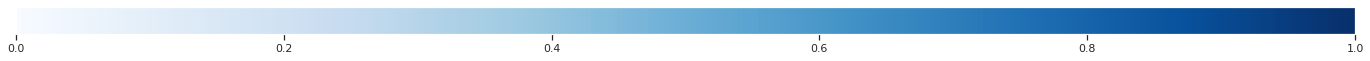

In [ ]:
f1_scores = evaluate_models(best_models, X_test_padded, y_test_hot, pos_filters_enc, plot=True)

In [ ]:
print('The f1 scores of the best models on the test set are:')
for model, f1 in zip(best_models, f1_scores):
  print('\t',model.name,':',f1)

The f1 scores of the best models on the test set are:
	 dense : 0.7768385640718394
	 baseline : 0.7975307190953391


### Hyperparameters tuning

We will try, as an extra work, to boost the performance of the baseline model by tuning some hyperparameters.

#### Using bigger GloVe embeddings

Let's see if, by choosing GloVes embeddings of size 300, the model's performance will increase.

In [ ]:
# Downloading GloVe 300
EMBEDDING_DIM = 300
gloves_300 = load_glove(EMBEDDING_DIM)

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
# Rebuild the embedding matrix
emb_300 = EmbeddingMatrixBuilder()
embeddings_300 = emb_300.build_embedding_matrix(gloves_300, EMBEDDING_DIM, word_seq.word_index)

Building embedding matrix..: 100%|██████████| 400575/400575 [00:01<00:00, 313166.80it/s]


In [ ]:
model_opt = get_model(embeddings_300.shape[0], 
                           num_classes+1, 
                           embeddings_300,
                           name='baseline_glove300')

In [ ]:
model_opt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_opt = model_opt.fit(x=X_train_padded, 
                              y=y_train_hot,
                              batch_size=batch_size, 
                              epochs=epochs, 
                              validation_data=(X_val_padded, y_val_hot),
                              callbacks=[EarlyStopByF1(val_data=(X_val_padded, y_val_hot), verbose=1, filters=pos_filters_enc)])

Epoch 1/100
246/246 [==============================] - 27s 74ms/step - loss: 0.1270 - accuracy: 0.6724 - val_loss: 0.1930 - val_accuracy: 0.8236 - val_f1: 0.5193
Epoch 2/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0466 - accuracy: 0.8699 - val_loss: 0.1365 - val_accuracy: 0.8695 - val_f1: 0.6486
Epoch 3/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0331 - accuracy: 0.9046 - val_loss: 0.1164 - val_accuracy: 0.8874 - val_f1: 0.6788
Epoch 4/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0258 - accuracy: 0.9264 - val_loss: 0.1037 - val_accuracy: 0.8962 - val_f1: 0.7068
Epoch 5/100
246/246 [==============================] - 10s 41ms/step - loss: 0.0204 - accuracy: 0.9429 - val_loss: 0.0957 - val_accuracy: 0.9048 - val_f1: 0.7467
Epoch 6/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0162 - accuracy: 0.9568 - val_loss: 0.0902 - val_accuracy: 0.9087 - val_f1: 0.7713
Epoch 7/100
246/246 [=======

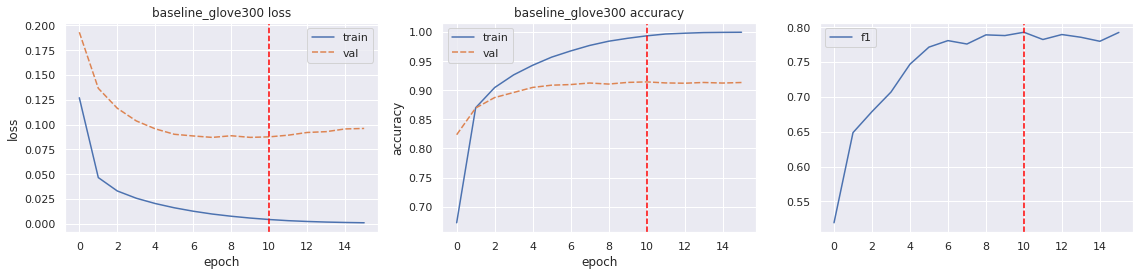

In [ ]:
plot_loss_accuracy_f1({model_opt.name:history_opt})

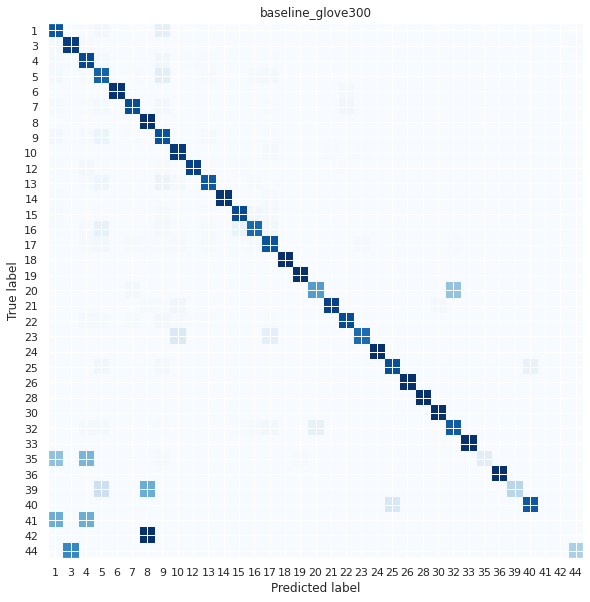

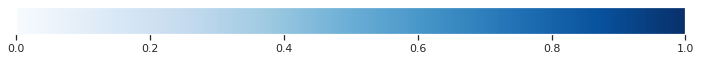

The f1 score of the baseline model with bigger GloVe embeddings is 0.793


In [ ]:
f1_opt = evaluate_models([model_opt], X_val_padded, y_val_hot, pos_filters_enc, plot=True)[0]
print('The f1 score of the baseline model with bigger GloVe embeddings is {:.3f}'.format(f1_opt))

Both the accuracy and the F1 score on the validation set are increased, even if the problem of the unbalanced classes persists. Let's move on by keeping this modification.

#### Sample Weights

As described before, the classes are unevely distributed in the training and validation sets.

During training, we will apply weights to each word of the sentences based on the corresponding POS tag, in order to balance the distribution of the classes.

We will implement it using the <code>sample_weight</code> argument in the <code>fit</code> method of the Keras models.



In [ ]:
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.array(range(1, num_classes+1)), 
                                     y=[item for sublist in y_train_encoded for item in sublist])
class_weights = np.array([0.0, *class_weights])

sample_weight_train = np.array(list(map(lambda x: class_weights[x], y_train_padded)))
sample_weight_val = np.array(list(map(lambda x: class_weights[x], y_val_padded)))

In [ ]:
model_opt = get_model(embeddings_300.shape[0], 
                           num_classes+1, 
                           embeddings_300,
                           name='baseline_sample_weights')

In [ ]:
model_opt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_opt = model_opt.fit(x=X_train_padded, 
                              y=y_train_hot,
                              batch_size=batch_size,
                              sample_weight=sample_weight_train,
                              epochs=epochs, 
                              validation_data=(X_val_padded, y_val_hot, sample_weight_val),
                              callbacks=[EarlyStopByF1(val_data=(X_val_padded, y_val_hot), verbose=1, filters=pos_filters_enc)])

Epoch 1/100
246/246 [==============================] - 27s 71ms/step - loss: 0.2735 - accuracy: 0.3089 - val_loss: 0.7242 - val_accuracy: 0.5464 - val_f1: 0.3829
Epoch 2/100
246/246 [==============================] - 10s 42ms/step - loss: 0.1073 - accuracy: 0.6058 - val_loss: 0.3962 - val_accuracy: 0.6687 - val_f1: 0.5103
Epoch 3/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0594 - accuracy: 0.7110 - val_loss: 0.3606 - val_accuracy: 0.7074 - val_f1: 0.5742
Epoch 4/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0423 - accuracy: 0.7671 - val_loss: 0.3358 - val_accuracy: 0.7697 - val_f1: 0.6255
Epoch 5/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0333 - accuracy: 0.8103 - val_loss: 0.3054 - val_accuracy: 0.7918 - val_f1: 0.6617
Epoch 6/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0268 - accuracy: 0.8344 - val_loss: 0.3290 - val_accuracy: 0.8150 - val_f1: 0.6790
Epoch 7/100
246/246 [=======

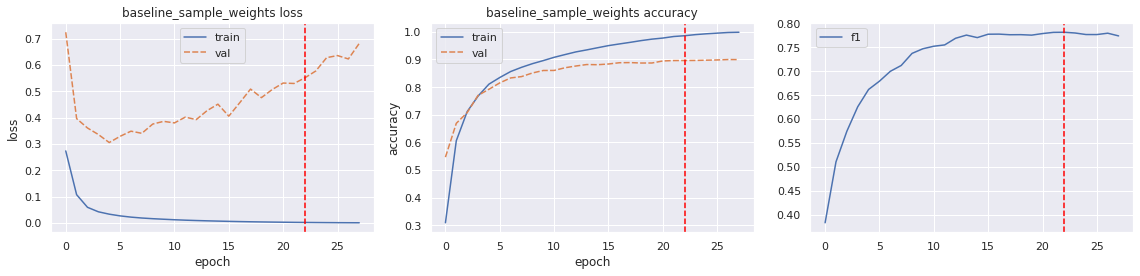

In [ ]:
plot_loss_accuracy_f1({model_opt.name:history_opt})

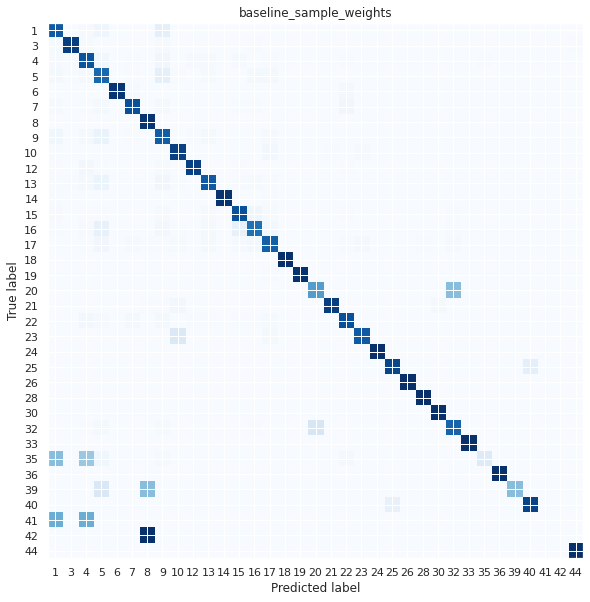

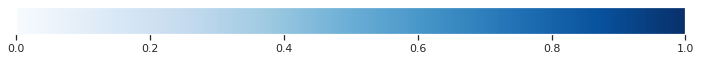

The f1 score of the baseline model with sample weights is 0.781


In [ ]:
f1_opt = evaluate_models([model_opt], X_val_padded, y_val_hot, pos_filters_enc, plot=True)[0]
print('The f1 score of the baseline model with sample weights is {:.3f}'.format(f1_opt))

The results on the validation set seem worse than before and the model starts to overfit quite early. It is plausible that, even if we apply high weights to the rarest classes, the samples in the training set are so poor that the model is not able to generalize them. Let's move on by discarding this modification.

#### Using bigger size of LSTM hidden states

We previously used as units dimension of the LSTM layer 100. Let's try to increase that number.

In [ ]:
model_opt = get_model(embeddings_300.shape[0], 
                         num_classes+1, 
                         embeddings_300, 
                         name='baseline_higher_units',
                         units=400)

In [ ]:
model_opt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_opt = model_opt.fit(x=X_train_padded, 
                              y=y_train_hot,
                              batch_size=batch_size, 
                              epochs=epochs, 
                              validation_data=(X_val_padded, y_val_hot),
                              callbacks=[EarlyStopByF1(val_data=(X_val_padded, y_val_hot), verbose=1, filters=pos_filters_enc)])

Epoch 1/100
246/246 [==============================] - 33s 90ms/step - loss: 0.0900 - accuracy: 0.7526 - val_loss: 0.1413 - val_accuracy: 0.8601 - val_f1: 0.6258
Epoch 2/100
246/246 [==============================] - 13s 52ms/step - loss: 0.0345 - accuracy: 0.8954 - val_loss: 0.1131 - val_accuracy: 0.8838 - val_f1: 0.6931
Epoch 3/100
246/246 [==============================] - 13s 52ms/step - loss: 0.0239 - accuracy: 0.9268 - val_loss: 0.1054 - val_accuracy: 0.8906 - val_f1: 0.7306
Epoch 4/100
246/246 [==============================] - 12s 51ms/step - loss: 0.0162 - accuracy: 0.9516 - val_loss: 0.0924 - val_accuracy: 0.9030 - val_f1: 0.7612
Epoch 5/100
246/246 [==============================] - 13s 53ms/step - loss: 0.0100 - accuracy: 0.9731 - val_loss: 0.0940 - val_accuracy: 0.9040 - val_f1: 0.7662
Epoch 6/100
246/246 [==============================] - 13s 52ms/step - loss: 0.0052 - accuracy: 0.9893 - val_loss: 0.0969 - val_accuracy: 0.9022 - val_f1: 0.7617
Epoch 7/100
246/246 [=======

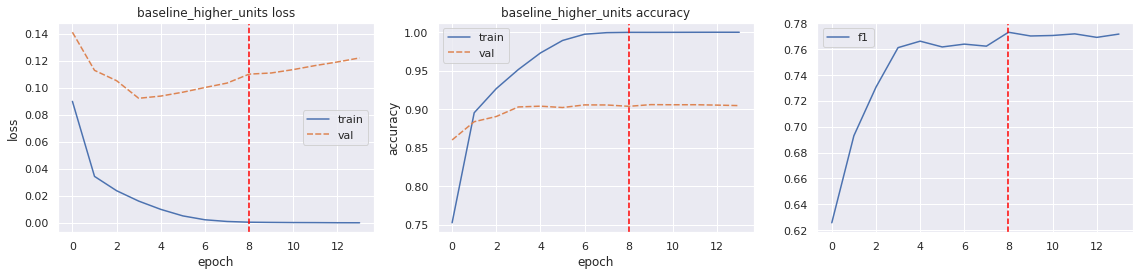

In [ ]:
plot_loss_accuracy_f1({model_opt.name:history_opt})

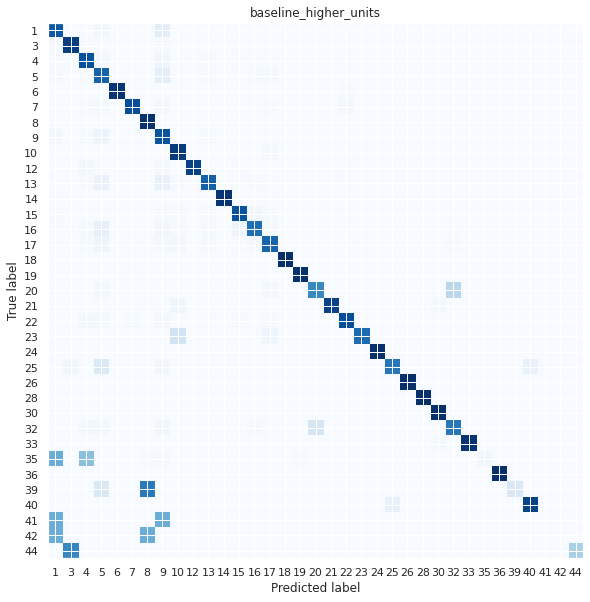

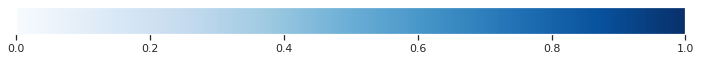

The f1 score of the baseline model with bigger hidden state's dimension is 0.773


In [ ]:
f1_opt = evaluate_models([model_opt], X_val_padded, y_val_hot, pos_filters_enc, plot=True)[0]
print('The f1 score of the baseline model with bigger hidden state\'s dimension is {:.3f}'.format(f1_opt))

The results on the validation set seems a little bit lower than the previous one but similar, but the model starts to overfit, starting from the third epoch. Let's move on by discarding this modification.

#### Gradient Normalization and Clipping

LSTM are good for handling long-term dependencies between intputs by trying to solve the vanishing gradient problem. But what about the exploding gradient one? Let's try to normalize the gradients' update values for the optimizer and then to "clip" the maximum possible gradient value to 0.5.

In [ ]:
model_opt = get_model(embeddings_300.shape[0], 
                      num_classes+1, 
                      embeddings_300,
                      name='baseline_gradient_norm_clip'
                     )

In [ ]:
optimizer = Adam(clipnorm=1., clipvalue=0.5)
model_opt.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history_opt = model_opt.fit(x=X_train_padded, 
                              y=y_train_hot, 
                              batch_size=batch_size, 
                              epochs=epochs, 
                              validation_data=(X_val_padded, y_val_hot),
                              callbacks=[EarlyStopByF1(val_data=(X_val_padded, y_val_hot), verbose=1, filters=pos_filters_enc)])

Epoch 1/100
246/246 [==============================] - 28s 76ms/step - loss: 0.1276 - accuracy: 0.6721 - val_loss: 0.1925 - val_accuracy: 0.8253 - val_f1: 0.5263
Epoch 2/100
246/246 [==============================] - 11s 44ms/step - loss: 0.0467 - accuracy: 0.8687 - val_loss: 0.1364 - val_accuracy: 0.8706 - val_f1: 0.6445
Epoch 3/100
246/246 [==============================] - 11s 43ms/step - loss: 0.0333 - accuracy: 0.9043 - val_loss: 0.1159 - val_accuracy: 0.8878 - val_f1: 0.6830
Epoch 4/100
246/246 [==============================] - 11s 43ms/step - loss: 0.0259 - accuracy: 0.9267 - val_loss: 0.1034 - val_accuracy: 0.8956 - val_f1: 0.7005
Epoch 5/100
246/246 [==============================] - 11s 44ms/step - loss: 0.0207 - accuracy: 0.9408 - val_loss: 0.0963 - val_accuracy: 0.9029 - val_f1: 0.7284
Epoch 6/100
246/246 [==============================] - 11s 43ms/step - loss: 0.0164 - accuracy: 0.9552 - val_loss: 0.0887 - val_accuracy: 0.9089 - val_f1: 0.7639
Epoch 7/100
246/246 [=======

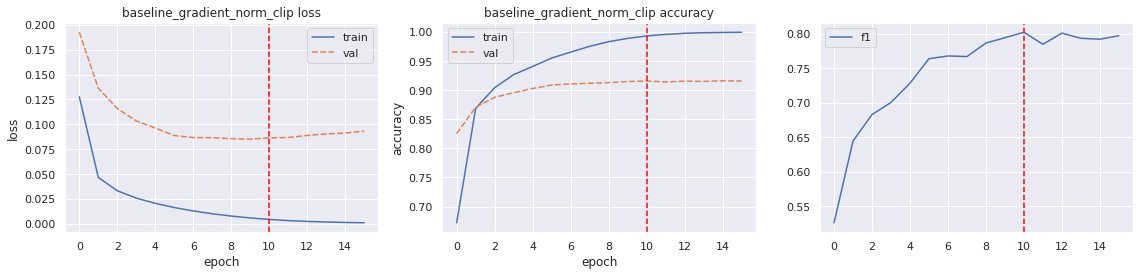

In [ ]:
plot_loss_accuracy_f1({model_opt.name:history_opt})

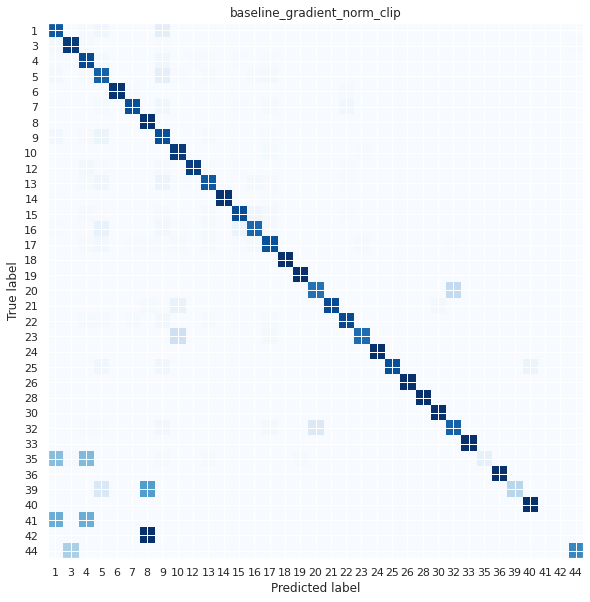

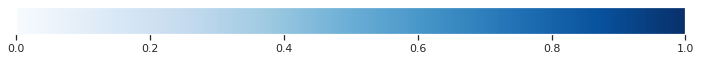

The f1 score of the baseline model with gradient norm+clipping is 0.802


In [ ]:
f1_opt = evaluate_models([model_opt], X_val_padded, y_val_hot, pos_filters_enc, plot=True)[0]
print('The f1 score of the baseline model with gradient norm+clipping is {:.3f}'.format(f1_opt))

The results on the validation set are a little bit better, but still similar to the best one so far. Probably the exploding gradient is not a big issue for this application. Anyway, let's keep this modification and move on.

#### Regularization

We will apply the dropout regularization to the baseline model with rate 0.3. In particular, we will add a Dropout layer after the Embedding Layer and "inside" the LSTM layer.

In [ ]:
model_opt = get_model(embeddings_300.shape[0], 
                         num_classes+1, 
                         embeddings_300,
                         name='baseline_dropout',
                         dropout=0.3,)

In [ ]:
optimizer = Adam(clipnorm=1., clipvalue=0.5)
model_opt.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history_opt = model_opt.fit(x=X_train_padded, 
                              y=y_train_hot,
                              batch_size=batch_size, 
                              epochs=epochs, 
                              validation_data=(X_val_padded, y_val_hot),
                              callbacks=[EarlyStopByF1(val_data=(X_val_padded, y_val_hot), verbose=1, filters=pos_filters_enc)])

Epoch 1/100
246/246 [==============================] - 27s 70ms/step - loss: 0.1467 - accuracy: 0.6106 - val_loss: 0.2207 - val_accuracy: 0.7938 - val_f1: 0.4786
Epoch 2/100
246/246 [==============================] - 11s 44ms/step - loss: 0.0667 - accuracy: 0.8025 - val_loss: 0.1592 - val_accuracy: 0.8434 - val_f1: 0.5874
Epoch 3/100
246/246 [==============================] - 11s 43ms/step - loss: 0.0531 - accuracy: 0.8400 - val_loss: 0.1355 - val_accuracy: 0.8661 - val_f1: 0.6409
Epoch 4/100
246/246 [==============================] - 11s 43ms/step - loss: 0.0457 - accuracy: 0.8597 - val_loss: 0.1196 - val_accuracy: 0.8790 - val_f1: 0.6705
Epoch 5/100
246/246 [==============================] - 11s 43ms/step - loss: 0.0404 - accuracy: 0.8736 - val_loss: 0.1092 - val_accuracy: 0.8895 - val_f1: 0.7004
Epoch 6/100
246/246 [==============================] - 11s 43ms/step - loss: 0.0364 - accuracy: 0.8864 - val_loss: 0.1014 - val_accuracy: 0.8962 - val_f1: 0.7166
Epoch 7/100
246/246 [=======

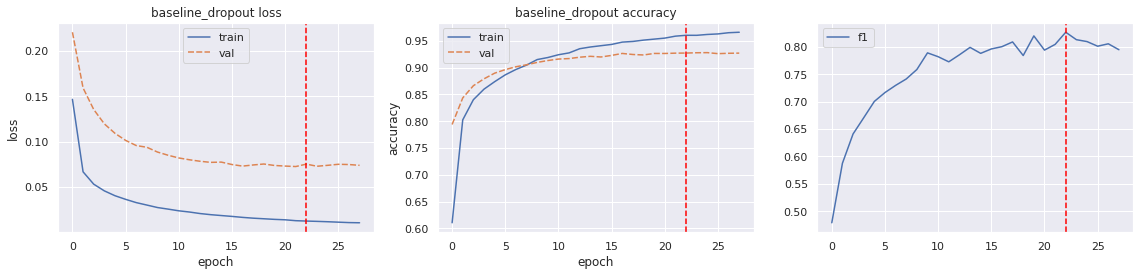

In [ ]:
plot_loss_accuracy_f1({model_opt.name:history_opt})

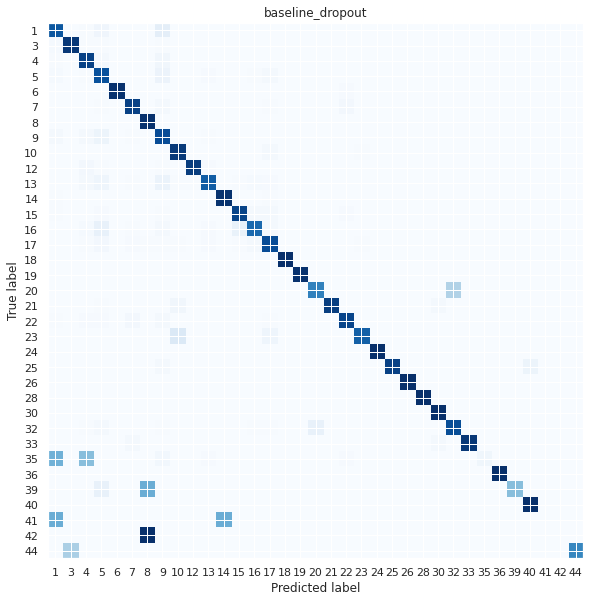

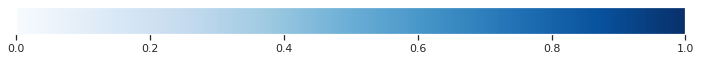

The f1 score of the baseline model with dropout regularization is 0.827


In [ ]:
f1_opt = evaluate_models([model_opt], X_val_padded, y_val_hot, pos_filters_enc, plot=True)[0]
print('The f1 score of the baseline model with dropout regularization is {:.3f}'.format(f1_opt))

The results on the validation are better w.r.t the previous one and the model seems to not overfit at all. 

Let's now evaluate the final model on the test set.

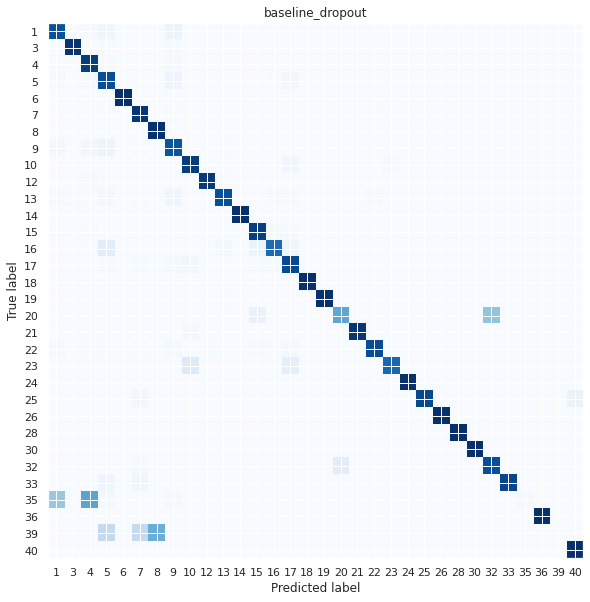

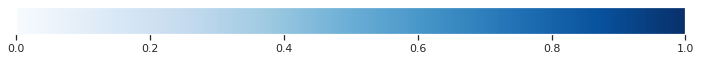

The f1 score of the optimized model on the test set is 0.858


In [ ]:
f1_opt = evaluate_models([model_opt], X_test_padded, y_test_hot, pos_filters_enc, plot=True)[0]
print('The f1 score of the optimized model on the test set is {:.3f}'.format(f1_opt))

In [ ]:
result = model_opt.evaluate(X_test_padded, y_test_hot, batch_size=batch_size, verbose=0)
print('The accuracy of the optimized model on the test set is {:.4f}'.format(result[1]))

The accuracy of the optimized model on the test set is 0.9289


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c7ea8d54-58f8-4744-83f6-d0882f3d6adf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>